# Data

Parse JSON

In [5]:
# add the parent directory to Python path
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

# load test json in jupyter notebook
import json
with open("../big_dataset.json") as f:
    dic = json.load(f)
    dic = dic["data"] # when run Launcher.ipynb, comment this out

import numpy as np
def get_subdic(dic, size=13):
    keys = list(dic.keys())
    selected_keys = np.random.choice(keys, size=size, replace=False)
    return {key: dic[key] for key in selected_keys}

# Parse data into assets and
from utils import json_parse
price_df, esg_s, asset_arr = json_parse(get_subdic(dic, size=23))

In [6]:
with open("../TEST_DATA.json", "w") as f:
    json.dump(dic, f, indent=2)  # indent=2 for pretty formatting

Preprocess μ and Σ

In [7]:
# Calculates mu and sigma using OAS, LedoitWolf or normal cov
from utils import compute_mu_sigma
mu, Sigma = compute_mu_sigma(price_df, lookback=252, shrinkage=True)

/home/jovyan/work/git/singapore25_challenge3_team9/et/../utils/Pre_processing.py:28: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices_df.pct_change().dropna() # percentage change between the current element and prior element


Helper function

In [8]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

    return selection

# Imports

In [9]:
# # Find all corrupted package directories
# !find /opt/conda/lib/python3.12/site-packages/ -name "*~*" -type d

# # Remove ALL corrupted package directories
# !find /opt/conda/lib/python3.12/site-packages/ -name "*~*" -type d -exec rm -rf {} +

In [10]:
# !pip uninstall qiskit qiskit-finance qiskit-aer qiskit-algorithms qiskit-optimization -y

In [11]:
# !pip install qiskit==1.4.2
# !pip install qiskit-finance==0.4.1
# !pip install qiskit-aer==0.13.3
# !pip install qiskit-algorithms==0.3.0
# !pip install qiskit-optimization==0.6.1

# !pip install qiskit-aer
# !pip install qiskit
# !pip install qiskit-algorithms
# !pip install qiskit-optimization
# !pip install qiskit-finance

In [12]:
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA
from qiskit_algorithms.optimizers import COBYLA
from myport import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

# QAOA solver

Using QAOA solver we are constarained to have our weightage $w\in\{0,1\}$.

$$
\min_{x\in\{0,1\}^n} qx^T\sum x - \mu^Tx
$$
This is subject to budget constaint:
$$
1^Tx=B\quad\text{(number of assests to be selected out of $n$)}
$$
The penalty term is therefore:
$$
P=\left(1^Tx-B\right)^2
$$

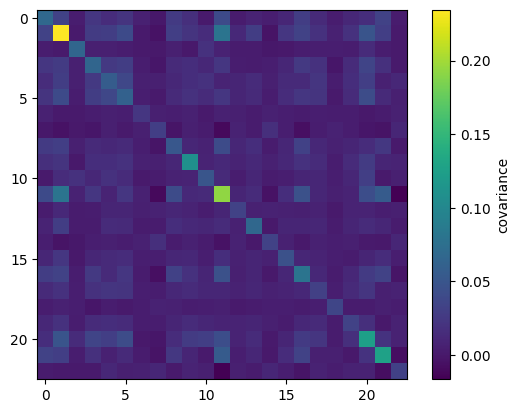

In [13]:
plt.imshow(Sigma, interpolation="nearest")
plt.colorbar(label="covariance")
plt.show()

In [14]:
# Create optimization equation
num_assets = len(mu)
q = 1  # set risk factor
budget = num_assets // 2  # set budget
penalty = min(num_assets, 1000)  # Cap the penalty (this is good assumption generally_

portfolio = PortfolioOptimization(expected_returns=mu, covariances=Sigma, risk_factor=q, budget=budget, esg_scores=esg_s, roi_factor=1, esg_factor=0.01)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.06871028592349918*x_0^2 + 0.06595725515670925*x_..., 23 variables, 1 constraints, 'Portfolio optimization'>

# Classical Eigensolver

In [17]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1.], value -5.1856

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 1]	-5.1856		1.0000


array([1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 1., 1.])

# Using QAOA

In [6]:
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA
from qiskit_algorithms.optimizers import COBYLA
from utils import PortfolioOptimization, print_result
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

from quantinuum_wrapper import QuantinuumWrapper
backend=QuantinuumWrapper.get_target()

q = 1  
num_assets = len(mu)
budget = num_assets // 2 
penalty = min(num_assets, 1000)  
portfolio = PortfolioOptimization(expected_returns=mu, covariances=Sigma, risk_factor=q, budget=budget, esg_scores=esg_s, roi_factor=1, esg_factor=0.01)
qp = portfolio.to_quadratic_program()
# Code for backend
cobyla = COBYLA()
cobyla.set_options(maxiter=250)

sampler = Sampler()
sampler.set_options(backend=backend)
qaoa_mes = QAOA(sampler=sampler, optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [7]:
%%timeit
result = qaoa.solve(qp)
q = print_result(result, portfolio, print_comb=False)

Optimal: selection [1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0.], value -3.9083
Optimal: selection [1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0.], value -4.2778
Optimal: selection [1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0.], value -4.0216
Optimal: selection [0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1.], value -4.0026
Optimal: selection [0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.], value -3.8847
Optimal: selection [0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0.], value -4.5997
Optimal: selection [0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1.], value -3.9248
Optimal: selection [1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.], value -4.2522
2min 2s ± 11.6 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


risk or credit score metric

In [18]:
print(q)

1


In [44]:
new = np.multiply(q,mu) / np.dot(np.multiply(q,mu),q)

In [49]:
sum(new)

0.9999999999999998